# Identification of Quora Duplicates using Machine Learning

<a id='toc'></a>
## Table of Contents
1. [Imports & Intialization](#init)
2. [Data Input](#data)
    1. [Read from file](#rdfile)
3. [Train-Test Split](#split)
4. [Preprocessing](#preproc)
    1. [Tokenizing](#token)
5. [Embedding - word2vec](#embed)
    1. [Load pretrained fasttext model](#loadw2v)
    2. [Transfer-train on training data](#retw2v)
6. [Feature Extraction](#featex)
    1. [Feature Sets 1 & 3 - Pairwise Distance & word2vec Vectors](#featset1)
        1. [Train - TF-IDF Vectorizer](#tr_tfidf)            
        2. [Function - TF-IDF Weights & word2vec Vectors](#f_tfidf_w2v)
        3. [Parallelization - Dask](#dask_init)
        4. [Functions - Pairwise Distances & Weighted Means](#f_pwise)
        5. [Compute - TF-IDF Weights & word2vec Vectors](#c_tfidf_w2v)
        6. [Compute - Pairwise Distances](#c_pwise)
    2. [Feature Set 2 - Fuzzy and Other Features](#featset2)
        1. [Functions - Fuzzy and Others](#f_fuzz)
        2. [Compute - Fuzzy and Others](#c_fuzz)
    3. [Assemble all Features sets](#ass_feat)
        1. [Functions - Add to train and test data](#f_ass)
        2. [Add to train data](#ass_train)
        3. [Add to test data](#ass_test)
7. [Feature Selection](#featsel)
    1. [Sort by Variance](#feat_var)
    2. [Sort by F-value](#feat_fval)
8. [Modeling](#model)
    1. [Logistic Regression](#logr)
        1. [Hyperparameter optimization](#logr_hyp)
        2. [Train optimized model](#logr_train)
        3. [Predict test data](#logr_pred)
        4. [Evaluate Model](#logr_eval)
    2. [Gradient Boosted Machine (XGBoost)](#gbm)
        1. [Hyperparameter optimization](#gbm_hyp)
        2. [Train optimized model](#gbm_train)
        3. [Predict test data](#gbm_pred)
        4. [Evaluate Model](#gbm_eval)

<a id='init'></a>
## Imports & Intialization
[back to table of contents](#toc)

In [117]:
import pandas as pd
from typing import List, Dict, Tuple
import numpy as np
import pickle
from scipy.io import mmwrite, mmread
from joblib import dump, load
from utils.utils import plot_roc, bar_plot_maker

import warnings
warnings.filterwarnings('ignore')

from toolz import partition_all

from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

import time

In [118]:
f_path = '/media/siri/78C6823EC681FD1E/minio/data/'
data_folder = f_path+'dq-data/v4/'
input_folder = f_path+'dq-data/'

In [142]:
def create_nan_array(r,c):
    arr = np.empty((r,c))
    arr[:] = np.nan
    return arr

<a id='data'></a>
## Data Input
[back to table of contents](#toc)

<a id='rdfile'></a>
### Read from file into dataframe
[back to table of contents](#toc)

In [ ]:
#load train_set
data = 'train.csv'
#filestream = ps.get_file_stream(bucket=INPUT_BUCKET, filename=data)
filestream = input_folder+data
dtypes = {
    'id': 'int64',
    'qid1': 'int64',
    'qid2': 'int64',
    'question1': 'object',
    'question2': 'object',
    'is_duplicate': 'int64'
}
df = pd.read_csv(#urlpath=s3_in_url, 
                                     #storage_options=s3_options,
                                     filestream,
                                     header=0, 
                                     usecols=dtypes.keys(), 
                                     #names=dtypes.keys(),
                                     skipinitialspace=True,
                                     skip_blank_lines=True,
                                     encoding='utf-8')
df = df.set_index('id')
df = df.dropna()

In [ ]:
#del df

<a id='split'></a>
## Train-test split
[back to table of contents](#toc)

In [ ]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['is_duplicate'])

y = df['is_duplicate']
X_train, X_test, y_train, y_test =  train_test_split(X, y, test_size=0.33, random_state=42)
X_train.info()

In [ ]:
pickle.dump(X_train, open(input_folder+'X_train.p', 'wb'))
pickle.dump(y_train, open(input_folder+'y_train.p', 'wb'))
pickle.dump(X_test, open(input_folder+'X_test.p', 'wb'))
pickle.dump(y_test, open(input_folder+'y_test.p', 'wb'))

In [ ]:
del X,y,df,X_train,X_test, y_train, y_test

<a id='preproc'></a>
## Preprocessing
[back to table of contents](#toc)

In [8]:
from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text
custom_filters = [strip_tags, strip_multiple_whitespaces, remove_stopwords, stem_text]
def get_tokenized_questions(run='train'):
    if run=='test':
        X = pickle.load(open(input_folder+'X_test.p', 'rb'))
    else:
        X = pickle.load(open(input_folder+'X_train.p', 'rb'))
    series = pd.Series(pd.concat([X['question1'], X['question2']]),dtype=str)
    series.dropna()
    for question in series:
        yield preprocess_string(question, custom_filters)

In [9]:
#common_terms = ["of", "with", "without", "and", "or", "the", "a"]
#phrases = gensim.models.Phrases(get_tokenized_questions('train'), common_terms=common_terms)

<a id='featex'></a>
## Feature Extraction
[back to table of contents](#toc)

<a id='token'></a>
### Tokenizing
[back to table of contents](#toc)

In [10]:
#def get_phrased_tknzd_questions(process):
#    return phrases[get_tokenized_questions(process)]

In [119]:
#function to get tokenize into tokens (that have valid vectors)
def get_tokens_for_valid_vectors(model, run):
    for question in get_tokenized_questions(run):
        tf_idf_tokens = []
        for token in question:
            try:
                vector = model.wv[token]
                tf_idf_tokens.append(token)
            except:
                continue
        yield np.array(tf_idf_tokens)

<a id='embed'></a>
### Embedding - word2vec
[back to table of contents](#toc)

<a id='loadw2v'></a>
#### Load pretrained fasttext model
[back to table of contents](#toc)

In [ ]:
from gensim.models import FastText
model = FastText.load_fasttext_format(data_folder+'cc.en.300.bin')

In [ ]:
#function to get word2vec vectors given pretrained model and run (train/test)
def get_ft_vectors(model, run):
    for tokens in get_tokens(run):
        vectors = []
        for token in tokens:
            try:
                vector = model.wv[token]
            except:
                continue
            vectors.append(vector)
        yield np.array(vectors)

<a id='retw2v'></a>
####  Transfer-train on training data
[back to table of contents](#toc)

In [15]:
tokenized_questions = [question for question in get_tokenized_questions('train')]

In [16]:
model_w2v = gensim.models.Word2Vec(tokenized_questions, size=300)

In [17]:
model_w2v.intersect_word2vec_format(input_folder+'GoogleNews-vectors-negative300.bin',
                                lockf=1.0,
                                binary=True)

In [18]:
model_w2v.train(tokenized_questions,total_examples=model_w2v.corpus_count, epochs=10)

(28534169, 35553200)

<a id='featset1'></a>
### Feature Sets 1 & 3 - Pairwise Distance & word2vec Vectors
[back to table of contents](#toc)

<a id='tr_tfidf'></a>
#### Train - TF-IDF Vectorizer
[back to table of contents](#toc)

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
pass_through = lambda x:x
tfidf = TfidfVectorizer(analyzer=pass_through)
X_trfmd = tfidf.fit_transform(get_tokens_for_valid_vectors(model_w2v,'train'))
# split into two (X1 -> set of first questions and X2 -> set of second questions)
X1_trfmd = X_trfmd[:len(X_train)]
X2_trfmd = X_trfmd[len(X_train):]

<a id='f_tfidf_w2v'></a>
#### Function - TF-IDF Weights & word2vec Vectors
[back to table of contents](#toc)

In [120]:
# function to compute TF-IDF weights as well as the word2vec vectors for all tokens
def get_weights_and_w2vectors(tfidf_matrix, tfidf_vectorizer, w2v_model):
    weights = []
    w2v = []
    rows = tfidf_matrix.shape[0]
    inverse_vocab_dict = {v: k for k, v in tfidf_vectorizer.vocabulary_.items()}
    for doc in range(rows):
        features = tfidf_matrix[doc,:].nonzero()[1]
        weights.append(np.array([tfidf_matrix[doc, x] for x in features]))
        w2v.append(np.array([w2v_model.wv[inverse_vocab_dict[x]] for x in features]))
    return np.array(weights), np.array(w2v)

<a id='c_tfidf_w2v'></a>
#### Compute - TF-IDF Weights & word2vec Vectors
[back to table of contents](#toc)

##### Train set

In [ ]:
X1_w, X1 = get_weights_and_w2vectors(X1_trfmd, tfidf, model_w2v)
X2_w, X2 = get_weights_and_w2vectors(X2_trfmd, tfidf, model_w2v)
pickle.dump(X1_w, open(data_folder+'X1_w.p','wb'))
pickle.dump(X2_w, open(data_folder+'X2_w.p','wb'))
pickle.dump(X1, open(data_folder+'X1.p','wb'))
pickle.dump(X2, open(data_folder+'X2.p','wb'))

In [127]:
del X1_w, X2_w, X1, X2

##### Test set

In [ ]:
X_test_trfmd = tfidf.transform(get_tokens_for_valid_vectors(model_w2v, 'test'))
# split back into two
X1_test_trfmd = X_test_trfmd[:len(X_test)]
X2_test_trfmd = X_test_trfmd[len(X_test):]

X1_test_w, X1_test = get_weights_and_w2vectors(X1_test_trfmd, tfidf, model_w2v)
X2_test_w, X2_test = get_weights_and_w2vectors(X2_test_trfmd, tfidf, model_w2v)
pickle.dump(X1_test_w, open(data_folder+'X1_test_w.p','wb'))
pickle.dump(X2_test_w, open(data_folder+'X2_test_w.p','wb'))
pickle.dump(X1_test, open(data_folder+'X1_test.p','wb'))
pickle.dump(X2_test, open(data_folder+'X2_test.p','wb'))

In [ ]:
del X1_test_w, X2_test_w, X1_test, X2_test

In [ ]:
del model_w2v

<a id='dask_init'></a>
#### Parallelization - Dask
[back to table of contents](#toc)

In [ ]:
#import dask.dataframe as dd
#from dask import delayed, compute
#from dask.distributed import Client
#from utils import dask
#client = dask.create_dask_client(num_workers=8)

<a id='f_pwise'></a>
#### Functions - Pairwise Distances & Weighted Means
[back to table of contents](#toc)

In [139]:
from sklearn.metrics.pairwise import linear_kernel, polynomial_kernel, sigmoid_kernel, laplacian_kernel, rbf_kernel
from sklearn.metrics import pairwise_distances
from scipy.spatial.distance import cdist, directed_hausdorff
from fastdtw import fastdtw
import similaritymeasures
from scipy.spatial import procrustes

# function for pairwise kernels
def compute_pairwise_kernel(pc1, pc2, w1, w2, method='linear'):
    if pc1.size == 0 or pc2.size == 0:
        return np.nan
    if method=='polynomial':
        dist_mat = polynomial_kernel(pc1, pc2, 2)
    elif method=='rbf':
        dist_mat = rbf_kernel(pc1, pc2)
    elif method=='sigmoid':
        dist_mat = sigmoid_kernel(pc1, pc2)
    elif method=='laplacian':
        dist_mat = laplacian_kernel(pc1, pc2)
    else:
        dist_mat = linear_kernel(pc1, pc2)
    return np.average(dist_mat, weights=np.matmul(w1.reshape(-1,1),w2.reshape(-1,1).T))

# function for pairwise distance metrics
def compute_pairwise_dist(pc1, pc2, w1, w2, method='euclidean'):
    if pc1.size == 0 or pc2.size == 0:
        return np.nan
    if method=='hausdorff':
        dist = directed_hausdorff(pc1, pc2)
        return dist[0]
    else:
        dist_mat = pairwise_distances(pc1, pc2, metric=method) 
    return np.average(dist_mat, weights=np.matmul(w1.reshape(-1,1),w2.reshape(-1,1).T))


# function for weighted mean
def compute_weighted_mean(pc, w):
    return np.average(pc, axis=0, weights=w)

In [140]:
#applies pairwise function to each row of the input vectors
def compute_delayed(X1, X2, X1_w, X2_w, method):
    temp = []
    for q_tuple in zip(X1, X2, X1_w, X2_w):
        if q_tuple:
            q1_rd, q2_rd, q1_w, q2_w = q_tuple
            if method in ['polynomial', 'rbf', 'sigmoid', 'laplacian', 'linear']:
                temp.append(compute_pairwise_kernel(q1_rd, q2_rd, q1_w, q2_w, method))
            else:
                temp.append(compute_pairwise_dist(q1_rd, q2_rd, q1_w, q2_w, method))
        else:
            temp.append(np.nan)
    return temp

def compute_delayed_wmean(X, X_w, file, data_folder=data_folder):
    temp = []
    for q_tuple in zip(X, X_w):
        if q_tuple:
            q_rd, q_w = q_tuple
            if np.sum(q_w) != 0:
                temp.append(compute_weighted_mean(q_rd, q_w))
            else:
                temp.append(create_nan_array(1,300))                    
        else:
            temp.append(create_nan_array(1,300))
    temp_arr = np.array(temp)
    pickle_and_del(temp_arr, file, data_folder) 

# pickles object and deletes from memory
def pickle_and_del(obj, file, data_folder=data_folder):
    pickle.dump(obj, open(data_folder+file+'.p', 'wb'))
    del obj
    
# computes pairwise metrics, weighted mean and saves to data_folder 
def compute_and_save(X1, X2, X1_w, X2_w, method, file, data_folder=data_folder):
    computed_obj = compute_delayed(X1, X2, X1_w, X2_w, method)
    pickle_and_del(computed_obj, file, data_folder) 

<a id='c_pwise'></a>
#### Compute - Pairwise Distances
[back to table of contents](#toc)

##### Train set

In [137]:
X1_w = pickle.load(open(data_folder+'X1_w.p','rb'))
X2_w = pickle.load(open(data_folder+'X2_w.p','rb'))
X1 = pickle.load(open(data_folder+'X1.p','rb'))
X2 = pickle.load(open(data_folder+'X2.p','rb'))

In [ ]:
#jaccard = compute(*jaccard)

#chebyshev
compute_and_save(X1, X2, X1_w, X2_w, 'chebyshev', 'chebyshev_train_w', data_folder)

#braycurtis
compute_and_save(X1, X2, X1_w, X2_w, 'braycurtis', 'braycurtis_train_w', data_folder)

#cosine
compute_and_save(X1, X2, X1_w, X2_w, 'cosine', 'cosine_train_w', data_folder)

#correlation
compute_and_save(X1, X2, X1_w, X2_w, 'correlation', 'correlation_train_w', data_folder)

#hamming = compute(*hamming)

#canberra
compute_and_save(X1, X2, X1_w, X2_w, 'canberra', 'canberra_train_w', data_folder)

#hausdorff
compute_and_save(X1, X2, X1_w, X2_w, 'hausdorff', 'hausdorff_train_w', data_folder)

#cityblock
compute_and_save(X1, X2, X1_w, X2_w, 'cityblock', 'cityblock_train_w', data_folder)

#euclidean
compute_and_save(X1, X2, X1_w, X2_w, 'euclidean', 'euclidean_train_w', data_folder)

#l1
compute_and_save(X1, X2, X1_w, X2_w, 'l1', 'l1_train_w', data_folder)

#l2
compute_and_save(X1, X2, X1_w, X2_w, 'l2', 'l2_train_w', data_folder)

#manhattan
compute_and_save(X1, X2, X1_w, X2_w, 'manhattan', 'manhattan_train_w', data_folder)

#dice = compute(*dice)
#kulsinski = compute(*kulsinski)
#rogerstanimoto = compute(*rogerstanimoto)
#russellrao = compute(*russellrao)
#sokalmichener = compute(*sokalmichener)
#seuclidean = compute(*seuclidean)
#sokalsneath = compute(*sokalsneath)

#minkowski
compute_and_save(X1, X2, X1_w, X2_w, 'minkowski', 'minkowski_train_w', data_folder)

#sqeuclidean
compute_and_save(X1, X2, X1_w, X2_w, 'sqeuclidean', 'sqeuclidean_train_w', data_folder)

#weighted_mean1
compute_delayed_wmean(X1, X1_w, 'weighted_mean1_train', data_folder)

#weighted_mean2
compute_delayed_wmean(X2, X2_w, 'weighted_mean2_train', data_folder)

#polynomial
#compute_and_save(X1, X2, X1_w, X2_w, 'polynomial', 'polynomial_train_w', data_folder)
#rbf
#compute_and_save(X1, X2, X1_w, X2_w, 'rbf', 'rbf_train_w', data_folder)
#sigmoid
#compute_and_save(X1, X2, X1_w, X2_w, 'sigmoid', 'sigmoid_train_w', data_folder)
#linear
#compute_and_save(X1, X2, X1_w, X2_w, 'linear', 'linear_train_w', data_folder)
#laplacian
#compute_and_save(X1, X2, X1_w, X2_w, 'laplacian', 'laplacian_train_w', data_folder)

#fdtw = compute(*fdtw)
#dtw = compute(*dtw)
#pcm = compute(*pcm)
#area = compute(*area)
#curve_length = compute(*curve_length)
#discrete_frechet = compute(*discrete_frechet)
#procrustes = compute(*procrustes)

In [143]:
#weighted_mean1
compute_delayed_wmean(X1, X1_w, 'weighted_mean1_train', data_folder)

#weighted_mean2
compute_delayed_wmean(X2, X2_w, 'weighted_mean2_train', data_folder)

In [135]:
del X1, X2, X1_w, X2_w

##### Test set

In [144]:
X1_test_w = pickle.load(open(data_folder+'X1_test_w.p','rb'))
X2_test_w = pickle.load(open(data_folder+'X2_test_w.p','rb'))
X1_test = pickle.load(open(data_folder+'X1_test.p','rb'))
X2_test = pickle.load(open(data_folder+'X2_test.p','rb'))

In [ ]:
#jaccard = compute(*jaccard)

#chebyshev
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'chebyshev', 'chebyshev_test_w', data_folder)

#braycurtis
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'braycurtis', 'braycurtis_test_w', data_folder)

#cosine
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'cosine', 'cosine_test_w', data_folder)

#correlation
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'correlation', 'correlation_test_w', data_folder)

#hamming = compute(*hamming)

#canberra
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'canberra', 'canberra_test_w', data_folder)

#hausdorff
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'hausdorff', 'hausdorff_test_w', data_folder)

#cityblock
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'cityblock', 'cityblock_test_w', data_folder)

#euclidean
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'euclidean', 'euclidean_test_w', data_folder)

#l1
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'l1', 'l1_test_w', data_folder)

#l2
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'l2', 'l2_test_w', data_folder)

#manhattan
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'manhattan', 'manhattan_test_w', data_folder)

#dice = compute(*dice)
#kulsinski = compute(*kulsinski)
#rogerstanimoto = compute(*rogerstanimoto)
#russellrao = compute(*russellrao)
#sokalmichener = compute(*sokalmichener)

#minkowski
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'minkowski', 'minkowski_test_w', data_folder)

#seuclidean = compute(*seuclidean)
#sokalsneath = compute(*sokalsneath)

#sqeuclidean
compute_and_save(X1_test, X2_test, X1_test_w, X2_test_w, 'sqeuclidean', 'sqeuclidean_test_w', data_folder)

#weighted_mean1
compute_delayed_wmean(X1_test, X1_test_w, 'weighted_mean1_test', data_folder)

#weighted_mean2
compute_delayed_wmean(X2_test, X2_test_w, 'weighted_mean2_test', data_folder)

#fdtw = compute(*fdtw)
#dtw = compute(*dtw)
#pcm = compute(*pcm)
#area = compute(*area)
#curve_length = compute(*curve_length)
#discrete_frechet = compute(*discrete_frechet)

In [128]:
#del X1_test, X2_test, X1_test_w, X2_test_w

<a id='featset2'></a>
### Feature Set 2 - Fuzzy and Other Features
[back to table of contents](#toc)

<a id='f_fuzz'></a>
#### Functions - Fuzzy and Others
[back to table of contents](#toc)

In [ ]:
from fuzzywuzzy import fuzz

# difference in text size
compute_size_diff = lambda row: abs(len(str(row['question1'])) - len(str(row['question2'])))

# ratio
compute_ratio = lambda row: fuzz.ratio(str(row['question1']), str(row['question2']))

# partial ratio
compute_partial_ratio = lambda row: fuzz.partial_ratio(str(row['question1']), str(row['question2']))

# token_sort_ratio
compute_token_sort_ratio = lambda row: fuzz.token_sort_ratio(str(row['question1']), str(row['question2']))

# token_set_ratio
compute_token_set_ratio = lambda row: fuzz.token_set_ratio(str(row['question1']), str(row['question2']))

# compute method on each row and save to data_folder
def compute_rowwise_and_save(X, method, file, data_folder=data_folder):
    computed_obj = X.apply(method, axis=1)
    pickle_and_del(computed_obj, file, data_folder)    

<a id='c_fuzz'></a>
#### Compute - Fuzzy and Others
[back to table of contents](#toc)

##### Train set

In [ ]:
# difference in text size
compute_rowwise_and_save(X_train, compute_size_diff, 'size_diff_train', data_folder=input_folder)

# ratio
compute_rowwise_and_save(X_train, compute_ratio, 'ratio_train', data_folder=input_folder)

# partial ratio
compute_rowwise_and_save(X_train, compute_partial_ratio, 'partial_ratio_train', data_folder=input_folder)

# token_sort_ratio
compute_rowwise_and_save(X_train, compute_token_sort_ratio, 'token_sort_ratio_train', data_folder=input_folder)

# token_set_ratio
compute_rowwise_and_save(X_train, compute_token_set_ratio, 'token_set_ratio_train', data_folder=input_folder)

##### Test set

In [ ]:
# difference in text size
compute_rowwise_and_save(X_test, compute_size_diff, 'size_diff_test', data_folder=input_folder)

# ratio
compute_rowwise_and_save(X_test, compute_ratio, 'ratio_test', data_folder=input_folder)

# partial ratio
compute_rowwise_and_save(X_test, compute_partial_ratio, 'partial_ratio_test', data_folder=input_folder)

# token_sort_ratio
compute_rowwise_and_save(X_test, compute_token_sort_ratio, 'token_sort_ratio_test', data_folder=input_folder)

# token_set_ratio
compute_rowwise_and_save(X_test, compute_token_set_ratio, 'token_set_ratio_test', data_folder=input_folder)

<a id='ass_feat'></a>
### Assemble all Features sets
[back to table of contents](#toc)

<a id='f_ass'></a>
#### Functions - Add to train and test data
[back to table of contents](#toc)

In [6]:
# add features from set 1 (pairwise metrics)
def add_column(df, column, train_or_test, data_folder=data_folder):
    col_arr = pickle.load(open(data_folder+column+'_'+train_or_test+'_w.p', 'rb'))
    return pd.concat([df,
                     pd.Series(col_arr, name=column,index=df.index)
                      ], axis=1)

# add features from set 3 (word2vec vectors)
def add_d2v_columns(df, d2v, train_or_test, red_type='umap', data_folder=data_folder):
    if red_type in ['svd','umap']:
        if red_type == 'svd':
            file = d2v+'_'+train_or_test+'_svd_red.p'
        else:
            file = d2v+'_'+train_or_test+'_red.p'
        col_arr = pickle.load(open(data_folder+file, 'rb'))
        return pd.concat([df,
                         pd.DataFrame(col_arr, columns=[d2v+'_'+str(i) for i in range(col_arr.shape[1])],index=df.index)
                          ], axis=1)
    else:
        file1 = 'weighted_mean1_'+train_or_test+'.p'        
        col_arr1 = pickle.load(open(data_folder+file1, 'rb'))
        file2 = 'weighted_mean2_'+train_or_test+'.p'        
        col_arr2 = pickle.load(open(data_folder+file2, 'rb'))
        col_arr = np.hstack((np.concatenate([x.reshape(1,-1) for x in col_arr1]), 
                   np.concatenate([x.reshape(1,-1) for x in col_arr2])))
        return pd.concat([df,
                     pd.DataFrame(col_arr, columns=[d2v+'_'+str(i) for i in range(col_arr.shape[1])],index=df.index)
                      ], axis=1)

# add features from set 2 (fuzzy metrics)
def add_fz_column(df, column, train_or_test, data_folder=input_folder):
    col_arr = pickle.load(open(data_folder+column+'_'+train_or_test+'.p', 'rb'))
    return pd.concat([df,
                     pd.Series(col_arr, name=column,index=df.index)
                      ], axis=1)

<a id='ass_train'></a>
#### Add to train data
[back to table of contents](#toc)

In [145]:
X_train = pickle.load(open(input_folder+'X_train.p', 'rb'))
y_train = pickle.load(open(input_folder+'y_train.p', 'rb'))

X_train = add_column(X_train, 'chebyshev', 'train')

X_train = add_column(X_train, 'braycurtis', 'train')

X_train = add_column(X_train, 'cosine', 'train')

X_train = add_column(X_train, 'correlation', 'train')

X_train = add_column(X_train, 'canberra', 'train')

X_train = add_column(X_train, 'hausdorff', 'train')

X_train = add_column(X_train, 'cityblock', 'train')

X_train = add_column(X_train, 'euclidean', 'train')

X_train = add_column(X_train, 'l1', 'train')

X_train = add_column(X_train, 'l2', 'train')

X_train = add_column(X_train, 'manhattan', 'train')

X_train = add_column(X_train, 'minkowski', 'train')

X_train = add_column(X_train, 'sqeuclidean', 'train')

#X_train = add_d2v_columns(X_train, 'd2v_1_10', 'train', 'svd')
X_train = add_d2v_columns(X_train, 'd2v_1_10', 'train', 'none')

#X_train = add_d2v_columns(X_train, 'd2v_2_10', 'train', 'svd')

X_train = add_fz_column(X_train, 'size_diff', 'train')

X_train = add_fz_column(X_train, 'ratio', 'train')

X_train = add_fz_column(X_train, 'partial_ratio', 'train')

X_train = add_fz_column(X_train, 'token_sort_ratio', 'train')

X_train = add_fz_column(X_train, 'token_set_ratio', 'train')

X_train.head()

,qid1,qid2,question1,question2,chebyshev,braycurtis,cosine,correlation,canberra,hausdorff,...,d2v_1_10_595,d2v_1_10_596,d2v_1_10_597,d2v_1_10_598,d2v_1_10_599,size_diff,ratio,partial_ratio,token_sort_ratio,token_set_ratio
id,,,,,,,,,,,,,,,,,,,,,
186150,284024,284025,"What is the difference between ""visa on arriva...",Do I need a visa to visit Ireland from England?,2.965800,0.901326,0.848629,0.852019,218.561842,17.222792,...,0.331072,-0.472701,-0.133261,0.190677,0.214852,56,37,47,44,43
208652,312703,312704,What are the chances of receiving invitation t...,What are the chances of receiving invitation t...,1.239341,0.704337,0.607015,0.609280,187.384261,1.398811,...,0.141595,-0.194436,-0.156675,-0.106556,0.137326,0,99,99,99,99
268163,385651,385652,"Is the phrase ""the pressure in an incompressib...",What is the use of Bash in Windows?,1.765565,0.956991,0.949161,0.949643,229.710165,14.845293,...,0.182944,-0.237980,0.072092,0.001290,-0.057096,115,25,51,25,42
155539,243655,243656,How do I buy goods from Amazon and ship to Vie...,How can I sell Vietnam traditional silk ties o...,1.927328,0.863107,0.819401,0.819126,210.260305,16.840177,...,0.225940,-0.144653,-0.188190,-0.041140,0.189528,58,48,51,54,67
212779,317931,317932,How do you read tarot cards?,How do I read tarot cards?,1.722557,0.611405,0.607047,0.607758,144.259087,0.000000,...,-0.098703,0.048941,-0.049272,0.014116,-0.098680,2,93,88,88,96


In [148]:
#X_train[X_train.isnull().any(axis=1)]

In [147]:
#X_train = pd.concat([X_train_temp, X_train], axis=1)
#del X_train_temp
X_train_final = X_train.drop(columns=['qid1', 'qid2','question1','question2']).dropna()
#X_train_final.info()

<a id='ass_test'></a>
#### Add to test data
[back to table of contents](#toc)

In [149]:
X_test = pickle.load(open(input_folder+'X_test.p', 'rb'))
y_test = pickle.load(open(input_folder+'y_test.p', 'rb'))

X_test = add_column(X_test, 'chebyshev', 'test')

X_test = add_column(X_test, 'braycurtis', 'test')

X_test = add_column(X_test, 'cosine', 'test')

X_test = add_column(X_test, 'correlation', 'test')

X_test = add_column(X_test, 'canberra', 'test')

X_test = add_column(X_test, 'hausdorff', 'test')

X_test = add_column(X_test, 'cityblock', 'test')

X_test = add_column(X_test, 'euclidean', 'test')

X_test = add_column(X_test, 'l1', 'test')

X_test = add_column(X_test, 'l2', 'test')

X_test = add_column(X_test, 'manhattan', 'test')

X_test = add_column(X_test, 'minkowski', 'test')

X_test = add_column(X_test, 'sqeuclidean', 'test')

#X_test = add_d2v_columns(X_test, 'd2v_1_10', 'test', 'svd')
X_test = add_d2v_columns(X_test, 'd2v_1_10', 'test', 'none')

#X_test = add_d2v_columns(X_test, 'd2v_2_10', 'test', 'svd')

X_test = add_fz_column(X_test, 'size_diff', 'test')

X_test = add_fz_column(X_test, 'ratio', 'test')

X_test = add_fz_column(X_test, 'partial_ratio', 'test')

X_test = add_fz_column(X_test, 'token_sort_ratio', 'test')

X_test = add_fz_column(X_test, 'token_set_ratio', 'test')

X_test.head()

,qid1,qid2,question1,question2,chebyshev,braycurtis,cosine,correlation,canberra,hausdorff,...,d2v_1_10_595,d2v_1_10_596,d2v_1_10_597,d2v_1_10_598,d2v_1_10_599,size_diff,ratio,partial_ratio,token_sort_ratio,token_set_ratio
id,,,,,,,,,,,,,,,,,,,,,
8067,15738,15739,How do I play Pokémon GO in Korea?,How do I play Pokémon GO in China?,1.769821,0.741648,0.696490,0.699882,181.962368,4.060278,...,-0.013804,-0.040093,-0.387248,0.105253,0.424973,0,88,88,81,90
224279,332326,332327,Will a breathing treatment help a cough?,How can I help someone that is unconscious but...,1.950689,0.825445,0.743469,0.743084,213.928196,19.856354,...,-0.008332,-0.012397,0.129785,-0.008097,0.203450,23,33,38,48,55
252452,336023,366789,Is Kellyanne Conway annoying in your opinion?,Did Kellyanne Conway really imply that we shou...,1.738898,0.862250,0.794070,0.793072,213.999636,14.355124,...,-0.176817,0.092989,-0.085044,-0.094556,0.109324,73,40,56,43,53
174039,268330,268331,How do you rate (1-10) and review Maruti Baleno?,What career options does one have after comple...,2.689103,0.944484,0.927694,0.931001,221.448653,14.901773,...,0.155024,-0.270503,-0.861722,0.399921,0.290907,79,30,42,32,33
384863,28901,233483,What are some good books on marketing?,What are some of the best books ever written a...,2.436946,0.730377,0.710170,0.710033,172.147518,15.469499,...,0.301538,-0.050691,-0.051994,0.090243,-0.341444,23,69,61,66,88


In [150]:
#X_test[X_test.isnull().any(axis=1)]

In [151]:
X_test_final = X_test.drop(columns=['question1','question2', 'qid1', 'qid2']).dropna()
X_test_final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 133392 entries, 8067 to 346580
Columns: 618 entries, chebyshev to token_set_ratio
dtypes: float64(613), int64(5)
memory usage: 630.0 MB


<a id='featsel'></a>
## Feature Selection
[back to table of contents](#toc)

<a id='feat_var'></a>
### Sort by Variance
[back to table of contents](#toc)

In [54]:
from sklearn.feature_selection import VarianceThreshold

threshold=(.8 * (1 - .8))

sel = VarianceThreshold(threshold=threshold)

sel.fit_transform(X_train_final)

variances = pd.DataFrame(sel.variances_, columns=['variance'])
variances['feature'] = X_train_final.columns

var_sorted = variances[variances.variance > threshold].sort_values(by='variance',ascending=False)
var_sorted

In [104]:
from matplotlib.ticker import ScalarFormatter
sns.set_context('paper')
sns.set_style('darkgrid')

# funtion to plot a barchart (long-form) with option to have log scale along x
def bar_plot_maker1(data, value_col, name_col, label, title, logscale=False, xticks=None, xticklabels=None, figsize=(7,10)):
    f, ax = plt.subplots(figsize=figsize)
    # Plot variances
    sns.set_color_codes("pastel")
    sns.barplot(x=value_col, y=name_col, data=data,
                label=label, color="b")

    # Add a legend and informative axis label
    ax.legend(ncol=1, loc="lower right", frameon=True)
    if logscale:
        ax.set(ylabel="", title=title, xscale='log')#, xticks=xticks, xticklabels=xticklabels)
        ax.get_xaxis().set_major_formatter(ScalarFormatter())
    else:        
        ax.set(ylabel="", title=title, xticks=xticks, xticklabels=xticklabels)
    sns.despine(left=True, bottom=True)

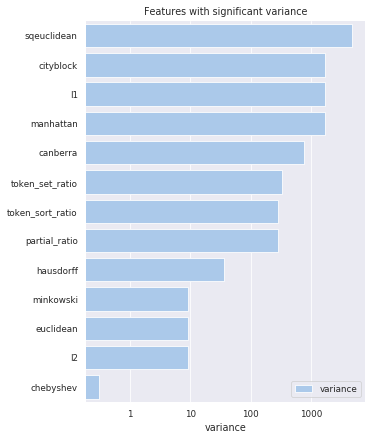

In [105]:
bar_plot_maker1(var_sorted, value_col='variance', name_col='feature', 
               label='variance', title='Features with significant variance',
               logscale=True, xticks=[0,2,4], xticklabels=['1','100','10000'],
               figsize=(5,7))

<a id='feat_fval'></a>
### Sort by F-value
[back to table of contents](#toc)

In [106]:
y_train_final = y_train.loc[X_train_final.index]

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2, mutual_info_classif, f_classif
kbest = SelectKBest(f_classif, k='all')
X_new = kbest.fit_transform(X_train_final, y_train_final)
X_new.shape

kbest_scores = pd.DataFrame(np.hstack((kbest.scores_.reshape(-1,1),
                                       kbest.pvalues_.reshape(-1,1), 
                                       np.array(X_train_final.columns).reshape(-1,1))), 
                            columns=['score','p-value', 'feature'])

kbest_scores_sorted = kbest_scores.sort_values(by=['score'],ascending=False)
kbest_scores_sorted

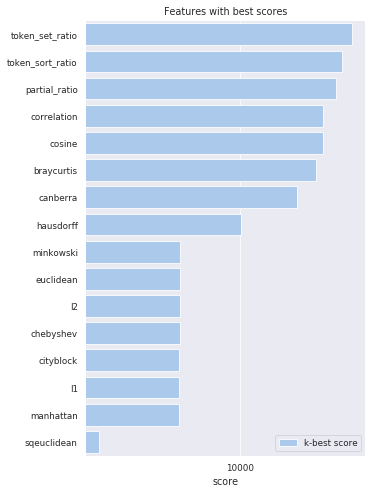

In [110]:
bar_plot_maker1(kbest_scores_sorted, value_col='score', name_col='feature', 
               label='k-best score', title='Features with best scores',
               logscale=True, xticks=[1,3,5], xticklabels=['1','1000','100000'],
               figsize=(5,8))

<a id='model'></a>
## Modeling
[back to table of contents](#toc)

### Imports and constants

In [152]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import classification_report
from sklearn.metrics import classification_report
from sklearn.metrics import roc_curve, auc

y_train_final = y_train.loc[X_train_final.index]

y_test_final = y_test.loc[X_test_final.index]

target_names = ['not duplicate', 'duplicate']

<a id='logr'></a>
### Logistic Regression
[back to table of contents](#toc)

<a id='logr_hyp'></a>
#### Hyperparameter optimization
[back to table of contents](#toc)

In [74]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

logr_model = LogisticRegression(random_state=42)
param_grid = {'C': np.logspace(-2, 7, 10),
             #'penalty': ['l1','l2'],
             'tol': np.logspace(-5, -1, 5),
             #'solver': ['lbfgs']
             #'max_iter': np.linspace(10, 1000, 10)
             }
logr_cv = RandomizedSearchCV(logr_model, param_distributions=param_grid, cv=5, n_jobs=-1)
logr_cv.fit(X_train_final, y_train_final)

dump(logr_cv, input_folder+'logr_ramdomcv.joblib')

In [129]:
logr_cv = load(input_folder+'logr_ramdomcv.joblib')

In [130]:
logr_cv.best_params_

{'tol': 1e-05, 'C': 100.0}

<a id='logr_train'></a>
#### Train optimized model
[back to table of contents](#toc)

In [154]:
from sklearn.linear_model import LogisticRegression
logr_model = LogisticRegression(#solver=logr_cv.best_params_['solver'], 
                                random_state=42, 
                                C=logr_cv.best_params_['C'], 
                                tol=logr_cv.best_params_['tol'], 
                                #max_iter=logr_cv.best_params_['max_iter'], 
                                n_jobs=-1)
logr_model.fit(X_train_final, y_train_final)

LogisticRegression(C=100.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn', n_jobs=-1,
          penalty='l2', random_state=42, solver='warn', tol=1e-05,
          verbose=0, warm_start=False)

<a id='logr_pred'></a>
#### Predict test data
[back to table of contents](#toc)

In [155]:
logr_pred = logr_model.predict(X_test_final)

<a id='logr_eval'></a>
#### Evaluate Model
[back to table of contents](#toc)

In [156]:
logr_acc_score = accuracy_score(y_test_final, logr_pred)
logr_prec_score = precision_score(y_test_final, logr_pred)
logr_rec_score = recall_score(y_test_final, logr_pred)
print('Logistic Regression')
print('accuracy score : {}'.format(logr_acc_score))
print('precision score : {}'.format(logr_prec_score))
print('recall score : {}'.format(logr_rec_score))

Logistic Regression
accuracy score : 0.7483057454719924
precision score : 0.6807838766601653
recall score : 0.596589752980914


In [157]:
print(classification_report(y_test_final, logr_pred, target_names=target_names))

               precision    recall  f1-score   support

not duplicate       0.78      0.84      0.81     84246
    duplicate       0.68      0.60      0.64     49146

    micro avg       0.75      0.75      0.75    133392
    macro avg       0.73      0.72      0.72    133392
 weighted avg       0.74      0.75      0.74    133392



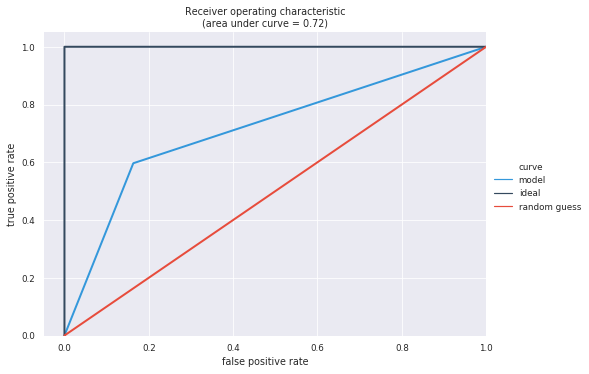

In [158]:
logr_fpr, logr_tpr, _ = roc_curve(y_test_final, logr_pred)
logr_roc_auc = auc(logr_fpr, logr_tpr)

plot_roc(logr_fpr, logr_tpr, logr_roc_auc)

<a id='gbm'></a>
### Gradient Boosted Machine (XGBoost)
[back to table of contents](#toc)

In [85]:
import xgboost as xgb

<a id='gbm_hyp'></a>
#### Hyperparameter optimization
[back to table of contents](#toc)

In [ ]:
# Model selection
params_xgb = {'n_estimators' : [1, 2, 4, 8, 16, 32, 64, 100, 200],
               'gamma':np.linspace(.01, 1, 10, endpoint=True), 
               'learning_rate' : np.linspace(.01, 1, 10, endpoint=True),
               'reg_lambda': np.linspace(0.01, 10, 20, endpoint=True),
               'max_depth' : np.linspace(1, 32, 32, endpoint=True, dtype=int)
                 }
cv_xgb = RandomizedSearchCV(xgb.XGBClassifier(objective='binary:logistic', random_state=42), param_distributions=params_xgb, cv=5, n_jobs=3, random_state=42)
cv_xgb.fit(X_train_final, y_train_final)

In [ ]:
dump(cv_xgb, input_folder+'xgb_ramdomcv.joblib')

In [86]:
cv_xgb = load(input_folder+'xgb_ramdomcv.joblib')

In [87]:
cv_xgb.best_params_

{'reg_lambda': 6.319473684210527,
 'n_estimators': 200,
 'max_depth': 29,
 'learning_rate': 0.23,
 'gamma': 0.23}

<a id='gbm_train'></a>
#### Train optimized model
[back to table of contents](#toc)

In [90]:
clf_xgb_model = xgb.XGBClassifier(random_state=42,
                                  objective='binary:logistic',
                                  n_estimators=cv_xgb.best_params_['n_estimators'],
                                  gamma=cv_xgb.best_params_['gamma'],
                                  learning_rate=cv_xgb.best_params_['learning_rate'],
                                  reg_lambda=cv_xgb.best_params_['reg_lambda'],
                                  max_depth=cv_xgb.best_params_['max_depth'],
                                  n_jobs=-1)

t0 = time.time()
clf_xgb_model.fit(X_train_final, y_train_final)
t1 = time.time() - t0
print(t1)

<a id='gbm_pred'></a>
#### Predict test data
[back to table of contents](#toc)

In [ ]:
y_pred_xgb = clf_xgb_model.predict(X_test_final)

<a id='gbm_eval'></a>
#### Evaluate Model
[back to table of contents](#toc)

In [92]:
score_xgb = accuracy_score(y_test_final, y_pred_xgb)
rscore_xgb = recall_score(y_test_final, y_pred_xgb)
pscore_xgb = precision_score(y_test_final, y_pred_xgb)
print('Accuracy score for XGBoost ', score_xgb)
print('Recall score for XGBoost ', rscore_xgb)
print('Precision score for XGBoost ', pscore_xgb)

Accuracy score for XGBoost  0.8303946263643996
Recall score for XGBoost  0.7419728970821633
Precision score for XGBoost  0.7857481468712291


In [93]:
print(classification_report(y_test_final, y_pred_xgb, target_names=target_names))

               precision    recall  f1-score   support

not duplicate       0.85      0.88      0.87     84246
    duplicate       0.79      0.74      0.76     49146

    micro avg       0.83      0.83      0.83    133392
    macro avg       0.82      0.81      0.82    133392
 weighted avg       0.83      0.83      0.83    133392



In [94]:
xgb_fpr, xgb_tpr, _ = roc_curve(y_test_final, y_pred_xgb)
xgb_roc_auc = auc(xgb_fpr, xgb_tpr)

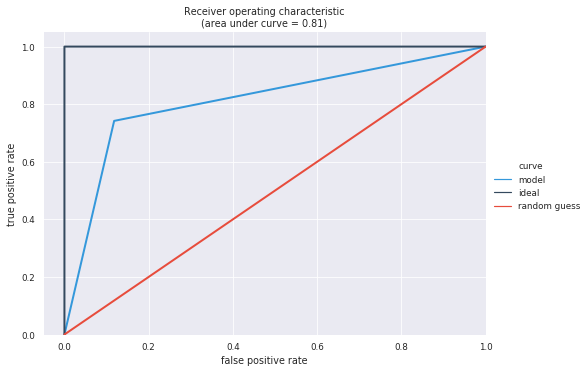

In [109]:
plot_roc(xgb_fpr, xgb_tpr, xgb_roc_auc)

#### Deprecated functions

In [ ]:
#def assign_pwmetric(df, method='euclidean'):
#    #return compute_pairwise_kernel(pc1_embd, pc2_embd, method=method)
#    return df.apply(compute_pairwise_dist, method, axis=1)


# function for special pairwise metrics
#def compute_pairwise_metric(pc1, pc2, method='dtw'):
#    if pc1.size == 0 or pc2.size == 0:
#        return np.nan
#    #if method=='fdtw':
#    #    dist, _ = fastdtw(pc1, pc2, dist=euclidean)
#    if method=='pcm':
#        dist = similaritymeasures.pcm(pc1[:,:2], pc2[:,:2])
#    if method=='discrete_frechet':
#        dist = similaritymeasures.frechet_dist(pc1[:,:2], pc2[:,:2])
#    if method=='area':
#        dist = similaritymeasures.area_between_two_curves(pc1[:,:2], pc2[:,:2])
#    if method=='curve_length':
#        dist = similaritymeasures.curve_length_measure(pc1[:,:2], pc2[:,:2])
#    if method=='dtw':
#        dist, _ = similaritymeasures.dtw(pc1[:,:2], pc2[:,:2])
#    #if method=='procrustes': 
#    #    mbox1 = MinimumBoundingBox([x[:2] for x in pc1.tolist()])
#    #    mbox2 = MinimumBoundingBox([x[:2] for x in pc2.tolist()])
#    #    _,_,dist = procrustes(make_array(mbox1.corner_points), make_array(mbox2.corner_points))
#    return dist    